In [1]:
import os, sys
import json
import gzip
import itertools
import collections
import importlib

import tqdm

import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

import anndata as ad
import scanpy as sc

import torch
import torch.nn as nn
import skorch
import skorch.helper

from transformers import BertModel, BertForMaskedLM, BertTokenizer, FeatureExtractionPipeline

SRC_DIR = os.path.join(os.path.dirname(os.getcwd()), "tcr")
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)
import custom_metrics
import data_loader as dl
import featurization as ft
import canonical_models as models
import model_utils
import plot_utils
import utils
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)
import transformer_custom as trans
import conv

TCRBERT = "wukevin/tcr-bert"

## Amino acid embeddings

Investigate amino acid embeddings

In [2]:
aa_prop = dl.load_aa_properties()
aa_prop.head()

,name,type
residue,,
R,Arginine,Positive
H,Histidine,Positive
K,Lysine,Positive
D,Aspartic acid,Negative
E,Glutamic acid,Negative


In [3]:
transformer_model = BertForMaskedLM.from_pretrained(TCRBERT)
aa_embeddings = transformer_model.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
aa_embeddings = np.delete(aa_embeddings, ft.get_aa_bert_tokenizer(64).all_special_ids, axis=0)

aa_embeddings_adata = ad.AnnData(
    aa_embeddings,
    obs=aa_prop,
)
aa_embeddings_adata

Some weights of the model checkpoint at wukevin/tcr-bert were not used when initializing BertForMaskedLM: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at wukevin/tcr-bert and are newly initialized: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
You should probably TRAIN this 

AnnData object with n_obs × n_vars = 21 × 768
    obs: 'name', 'type'

In [4]:
sc.pp.pca(aa_embeddings_adata, n_comps=2)
sc.pp.neighbors(aa_embeddings_adata, use_rep='X')
sc.tl.umap(aa_embeddings_adata)
sc.tl.tsne(aa_embeddings_adata)
aa_embeddings_adata

AnnData object with n_obs × n_vars = 21 × 768
    obs: 'name', 'type'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

... storing 'type' as categorical


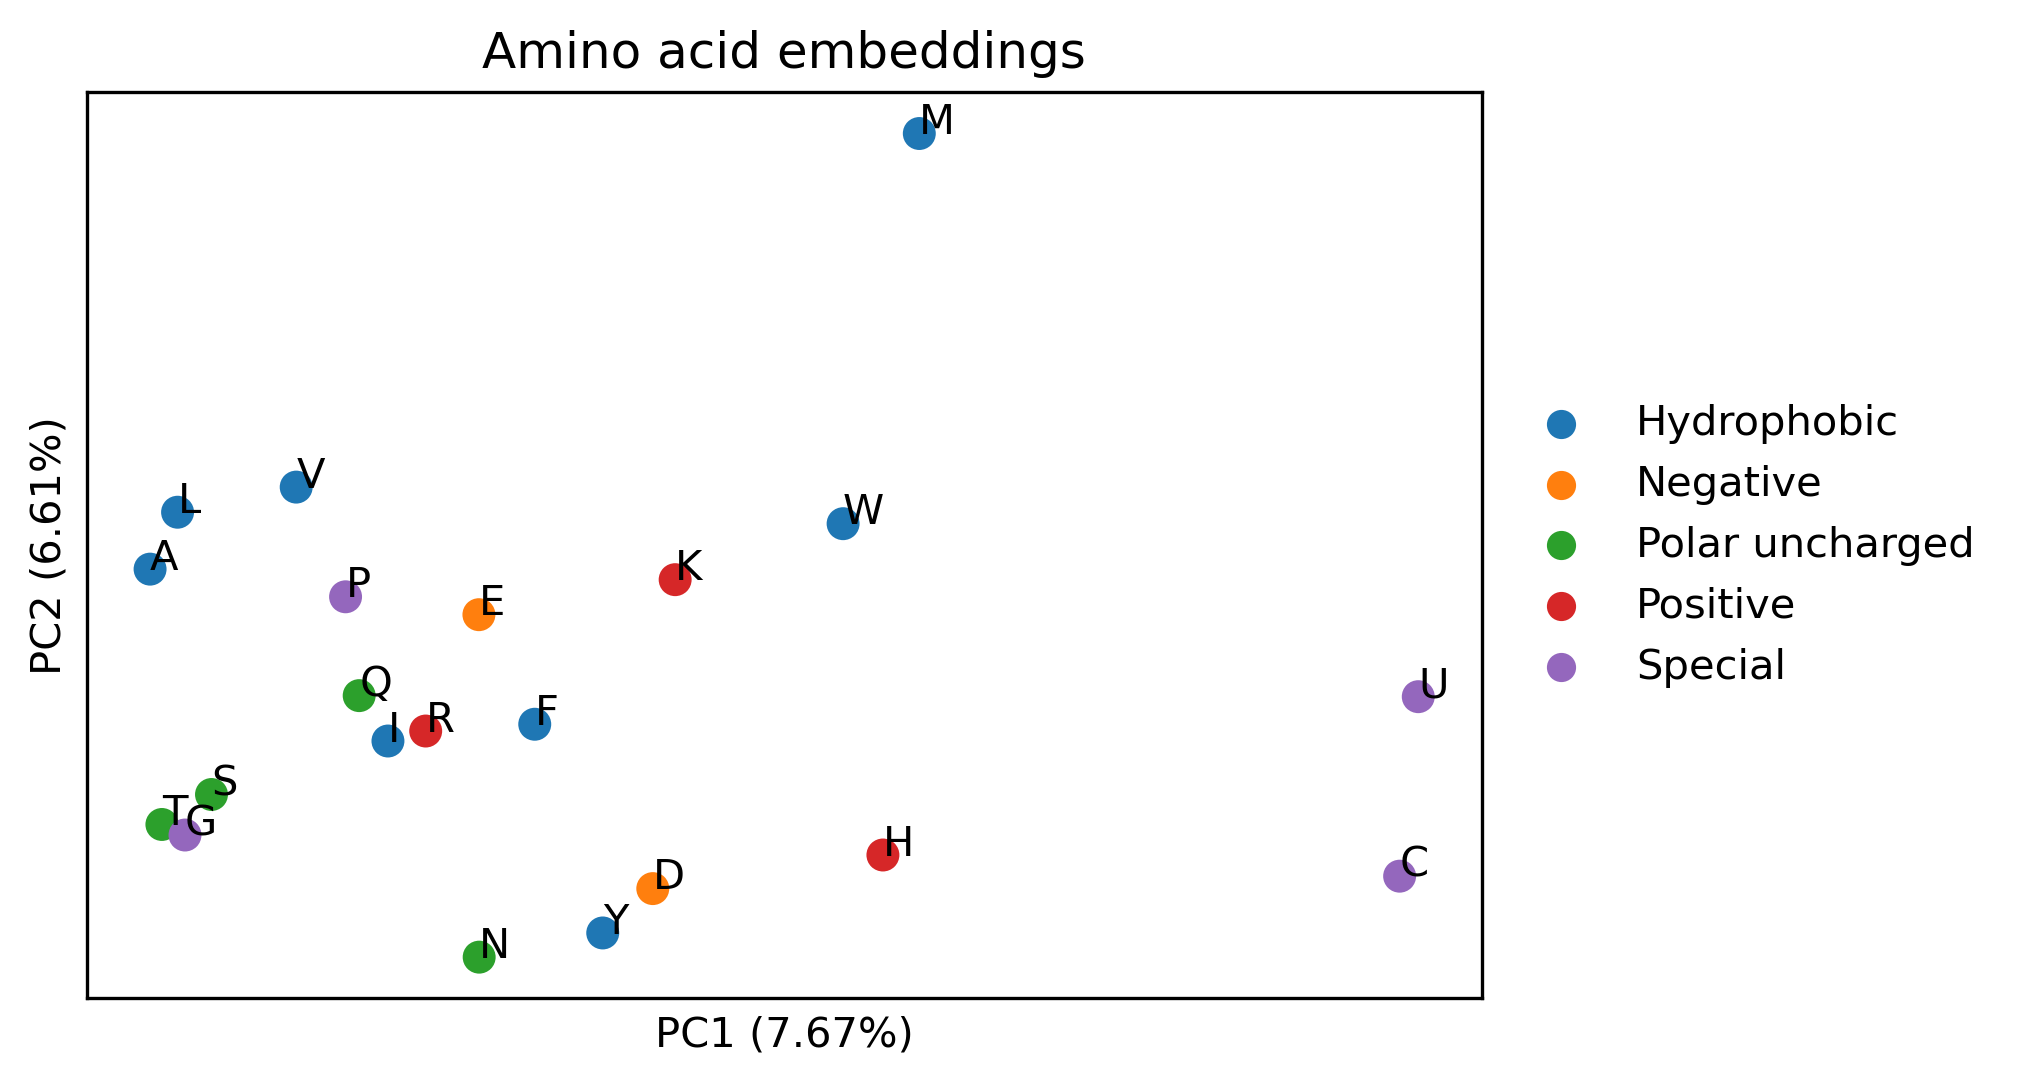

In [5]:
fig, ax = plt.subplots(dpi=300)
ax = sc.pl.pca(aa_embeddings_adata, color='type', size=250, ax=ax, annotate_var_explained=True, show=False)
for i, aa in enumerate(ft.AMINO_ACIDS):
    ax.annotate(
        aa,
        (aa_embeddings_adata.obsm['X_pca'][i, 0], aa_embeddings_adata.obsm['X_pca'][i, 1])
    )
ax.set(
    title="Amino acid embeddings",
)
fig.show()

## Layer selection

Select the layer that results in the best LCMV validation set performance.

In [6]:
importlib.reload(dl)
lcmv = dl.load_lcmv_table()
lcmv.head()

INFO:root:Loaded in table of 20351 entries
INFO:root:16768 entries remain after dropping na
INFO:root:15028 entries remain after dropping unsorted
INFO:root:20522 entries after expanding multiple entries
INFO:root:Class TetPos: 1819
INFO:root:Class TetNeg: 17477
INFO:root:Class TetMid: 1226


,tetramer,tcr_cdr3s_aa,tcr_cdr3s_nt,TRB,TRA,nCells,Prop,TRA_nt,TRB_nt,antigen.sequence,...,S.Score,G2M.Score,Phase,phenotype,chain,cdr3,v_gene,d_gene,j_gene,c_gene
0,TetPos,TRA:CAFEVVGQLTF;TRB:CASSFRDSSYEQYF,TRA:TGTGCTTTCGAGGTTGTGGGGCAGCTCACTTTC;TRB:TGTG...,CASSFRDSSYEQYF,CAFEVVGQLTF,3728,0.994664,TGTGCTTTCGAGGTTGTGGGGCAGCTCACTTTC,TGTGCCAGCAGTTTCAGGGACAGCTCCTATGAACAGTACTTC,KAVYNFATC,...,-0.010752,-0.050206,G1,TEx,TRA,CAFEVVGQLTF,TRAV16N,None,TRAJ5,TRAC
1,TetPos,TRA:CAVSAWVGDNSKLIW;TRB:CASSRDSLTEVFF,TRA:TGCGCAGTCAGTGCATGGGTTGGTGACAACAGTAAGCTGATT...,CASSRDSLTEVFF,CAVSAWVGDNSKLIW,1805,0.981512,TGCGCAGTCAGTGCATGGGTTGGTGACAACAGTAAGCTGATTTGG,TGTGCCAGCAGCCGGGACAGCTTGACAGAAGTCTTCTTT,KAVYNFATC,...,-0.100078,-0.016706,G1,TEx,TRA,CAVSAWVGDNSKLIW,TRAV3D-3,None,TRAJ38,TRAC
2,TetPos,TRA:CAQLEGADRLTF;TRB:CASSDHTNTEVFF,TRA:TGTGCTCAGTTAGAAGGTGCAGATAGACTCACCTTT;TRB:T...,CASSDHTNTEVFF,CAQLEGADRLTF,1299,0.999231,TGTGCTCAGTTAGAAGGTGCAGATAGACTCACCTTT,TGTGCCAGCAGTGATCACACAAACACAGAAGTCTTCTTT,KAVYNFATC,...,-0.112835,-0.128558,G1,TEx_progenitor,TRA,CAQLEGADRLTF,TRAV6-7-DV9,None,TRAJ45,TRAC
3,TetNeg,TRA:CAMSDLSNNAGAKLTF;TRB:CASSRDNNYAEQFF,TRA:TGTGCTATGAGTGATCTGAGTAATAATGCAGGTGCCAAGCTC...,CASSRDNNYAEQFF,CAMSDLSNNAGAKLTF,954,0.947368,TGTGCTATGAGTGATCTGAGTAATAATGCAGGTGCCAAGCTCACATTC,TGTGCTAGCAGCCGGGACAATAACTATGCTGAGCAGTTCTTC,KAVYNFATC,...,-0.075815,-0.128061,G1,TEx,TRB,CASSRDNNYAEQFF,TRBV17,None,TRBJ2-1,None
4,TetNeg,TRA:CALGLYGNEKITF;TRB:CASSVTSANTEVFF,TRA:TGTGCTCTGGGTCTCTATGGAAATGAGAAAATAACTTTT;TR...,CASSVTSANTEVFF,CALGLYGNEKITF,894,0.951064,TGTGCTCTGGGTCTCTATGGAAATGAGAAAATAACTTTT,TGTGCCAGCAGCGTGACAAGTGCAAACACAGAAGTCTTCTTT,KAVYNFATC,...,-0.129156,-0.089390,G1,TEx_transitory,TRA,CALGLYGNEKITF,TRAV6N-7,None,TRAJ48,TRAC


In [7]:
importlib.reload(dl)

lcmv_dedup_tra_trb, lcmv_dedup_labels = dl.dedup_lcmv_table(lcmv)
lcmv_dedup_tra, lcmv_dedup_trb = zip(*lcmv_dedup_tra_trb)
lcmv_dedup = pd.DataFrame(
    {
        "TRA": lcmv_dedup_tra,
        "TRB": lcmv_dedup_trb,
        "tetramer": lcmv_dedup_labels,
        "label": ["TetPos" in l or "TetMid" in l for l in lcmv_dedup_labels],
    }
)

# lcmv_dedup_trb, lcmv_dedup_labels = dl.dedup_lcmv_table_trb_only(lcmv)
# lcmv_dedup = pd.DataFrame(
#     {
#         "TRB": lcmv_dedup_trb,
#         "tetramer": lcmv_dedup_labels,
#         "label": ['TetPos' in l or 'TetMid' in l for l in lcmv_dedup_labels],
#     }
# )

lcmv_dedup.head()

INFO:root:Deduped from 20522 -> 17772 merging 101 labels
INFO:root:Combined labels [('TetNeg', 15396), ('TetPos', 1216), ('TetMid', 1059), ('TetMid,TetNeg', 55), ('TetMid,TetPos', 31), ('TetNeg,TetPos', 14), ('TetMid,TetNeg,TetPos', 1)]
INFO:root:Filtering out labels ('TetMid,TetNeg', 'TetNeg,TetPos', 'TetMid,TetNeg,TetPos')
INFO:root:Retaining 17702 pairs with unambiguous labels
INFO:root:LCMV deduped labels: [('TetNeg', 15396), ('TetPos', 1216), ('TetMid', 1059), ('TetMid,TetPos', 31)]


,TRA,TRB,tetramer,label
0,CAAAAAGNYKYVF,CASSLLGGSYEQYF,TetNeg,False
1,CAAAASNTNKVVF,CASSLGLGANTGQLYF,TetNeg,False
2,CAAAASSGSWQLIF,CASGPREANERLFF,TetNeg,False
3,CAAADNYAQGLTF,CASGEGPDYTF,TetNeg,False
4,CAAADNYAQGLTF,CASRDWGDEQYF,TetNeg,False


In [8]:
importlib.reload(dl)

def sweep_layers_models_and_ds(layers=[-6, -5, -4, -3, -2, -1], ds=[1/2, 1/5, 1/10, 1/20, 1/50], model_keywords=['pcasvm', 'svm', 'pcalr', 'lr']):
    """
    Sweep across all combinations of layers/ds/models
    """
    train_trbs = dl.split_arr(lcmv_dedup_trb, 'train')
    valid_trbs = dl.split_arr(lcmv_dedup_trb, 'valid')
    lcmv_labels = list(lcmv_dedup['label'])
    lcmv_train_labels = dl.split_arr(lcmv_labels, 'train')
    lcmv_valid_labels = dl.split_arr(lcmv_labels, 'valid')

    # Remove training TRBs that are also in validation
    train_trb_filt_idx = [i for i, b in enumerate(train_trbs) if b not in set(valid_trbs)]
    print(f"Retaining {len(train_trb_filt_idx)}/{len(train_trbs)} non-overlapping TRBs")
    train_trbs = [train_trbs[i] for i in train_trb_filt_idx]
    train_labels = [lcmv_train_labels[i] for i in train_trb_filt_idx]

    aurocs, auprcs = {}, {}
    for layer in tqdm.notebook.tqdm(layers):
        assert not set(train_trbs).intersection(valid_trbs)
        train_embed = model_utils.get_transformer_embeddings(TCRBERT, train_trbs, method='mean', layers=[layer], device=0)
        valid_embed = model_utils.get_transformer_embeddings(TCRBERT, valid_trbs, method='mean', layers=[layer], device=0)
        
        for d, cls_method in itertools.product(ds, model_keywords):
            downsample = int(round(d * len(train_embed)))
            assert downsample > 0

            model = None
            if cls_method == "pcasvm":
                model = models.ModelOnPCA(SVC, probability=True, kernel='rbf', n_components=0.9)
            elif cls_method == "svm":
                model = SVC(probability=True, kernel='rbf')
            elif cls_method == "pcalr":
                model = models.ModelOnPCA(LogisticRegression, solver='liblinear', n_components=0.9)
            elif cls_method == "lr":
                model = LogisticRegression(solver='liblinear')
            else:
                raise ValueError(f"Unrecognized cls method: {cls_method}")
            assert model is not None
            model.fit(train_embed[:downsample], lcmv_train_labels[:downsample])
            valid_preds = model.predict_proba(valid_embed)[:, 1]
            
            aurocs[(layer, d, cls_method)] = metrics.roc_auc_score(lcmv_valid_labels, valid_preds)
            auprcs[(layer, d, cls_method)] = metrics.average_precision_score(lcmv_valid_labels, valid_preds)
    return aurocs, auprcs

sweep_aurocs, sweep_auprcs = sweep_layers_models_and_ds()

Retaining 10607/12392 non-overlapping TRBs


Some weights of the model checkpoint at wukevin/tcr-bert were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at wukevin/tcr-bert were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS

In [9]:
def extract_unique_keys(results_dict):
    k = len(list(results_dict.keys())[0])
    retval = []
    for i in range(k):
        vals = sorted(list(set([tup[i] for tup in results_dict.keys()])))
        retval.append(vals)
    assert len(list(itertools.product(*retval))) == len(results_dict)
    return retval

def get_best_method(results_dict, verbose:bool=False):
    """Return the method that has the best overall performance"""
    layers, downsample_levels, cls_methods = extract_unique_keys(results_dict)
    # For each of the combinations of layer and downsample, record the best method
    per_method_perf = collections.defaultdict(list)
    winners = []  # By count
    for l, d in itertools.product(layers, downsample_levels):
        perfs = [results_dict[(l, d, m)] for m in cls_methods]
        for m in cls_methods:
            per_method_perf[m].append(results_dict[(l, d, m)])
        idx = np.argmax(perfs)
        winners.append(cls_methods[idx])
    assert len(winners) == len(list(itertools.product(layers, downsample_levels)))
    
    stat, pval = stats.wilcoxon(per_method_perf['svm'], per_method_perf['pcasvm'])

    cnt = collections.Counter(winners)
    if verbose:
        for a, b in itertools.combinations(cls_methods, 2):
            stat, pval = stats.wilcoxon(per_method_perf[a], per_method_perf[b])
            print(a, b, np.mean(per_method_perf[a]), np.mean(per_method_perf[b]), pval)
        print(cnt.most_common())
    return cnt.most_common()[0][0]

get_best_method(sweep_auprcs, verbose=True), get_best_method(sweep_aurocs, verbose=True)

lr pcalr 0.1281829513134888 0.1324862999176471 0.0041140307793227126
lr pcasvm 0.1281829513134888 0.1396343203646861 5.7924461897570095e-05
lr svm 0.1281829513134888 0.1406889499946086 2.1630223983536902e-05
pcalr pcasvm 0.1324862999176471 0.1396343203646861 0.0041140307793227126
pcalr svm 0.1324862999176471 0.1406889499946086 0.012452560438554458
pcasvm svm 0.1396343203646861 0.1406889499946086 0.9099307681587345
[('pcasvm', 12), ('svm', 10), ('pcalr', 8)]
lr pcalr 0.47304250586947333 0.4805481774955155 0.1020106952499886
lr pcasvm 0.47304250586947333 0.50972317024111 1.798848069179905e-05
lr svm 0.47304250586947333 0.5137991568402448 8.466081690383873e-06
pcalr pcasvm 0.4805481774955155 0.50972317024111 0.00035888445044696013
pcalr svm 0.4805481774955155 0.5137991568402448 0.00018909720229770685
pcasvm svm 0.50972317024111 0.5137991568402448 0.49079849348995086
[('svm', 14), ('pcasvm', 10), ('pcalr', 5), ('lr', 1)]


('pcasvm', 'svm')

In [10]:
def get_best_layer(results_dict, method:str):
    """Get the best layer for the given method"""
    layers, downsample_levels, cls_methods = extract_unique_keys(results_dict)
    df = pd.DataFrame(0, index=layers, columns=downsample_levels)
    for l, d in itertools.product(layers, downsample_levels):
        df.loc[l, d] = results_dict[(l, d, method)]
    relative_perf = df / df.max(axis=0)  # Normalize perf in each downsampling level by max in that level
    relative_perf_mean = relative_perf.mean(axis=1)  # Average fractional performance across downsampling levels
    return relative_perf_mean

pcasvm_relperf = pd.DataFrame(
    {'AUPRC': get_best_layer(sweep_auprcs, 'pcasvm'), 'AUROC': get_best_layer(sweep_aurocs, 'pcasvm')}
)
pcasvm_relperf

,AUPRC,AUROC
-6,0.928730,0.950021
-5,0.939486,0.966935
-4,0.952213,0.979708
-3,0.955935,0.974499
-2,0.973626,0.971145
-1,0.898461,0.928852


In [11]:
pcasvm_relperf.idxmax(axis=0)

AUPRC   -2
AUROC   -4
dtype: int64

In [12]:
svm_relperf = pd.DataFrame(
    {'AUPRC': get_best_layer(sweep_auprcs, 'svm'), 'AUROC': get_best_layer(sweep_aurocs, 'svm')}
)
svm_relperf

,AUPRC,AUROC
-6,0.912168,0.926856
-5,0.950605,0.968106
-4,0.906524,0.958662
-3,0.965870,0.984134
-2,0.972303,0.983029
-1,0.974139,0.985316


In [13]:
svm_relperf.idxmax(axis=0), svm_relperf.sum(axis=1).idxmax(axis=0)

(AUPRC   -1
 AUROC   -1
 dtype: int64,
 -1)

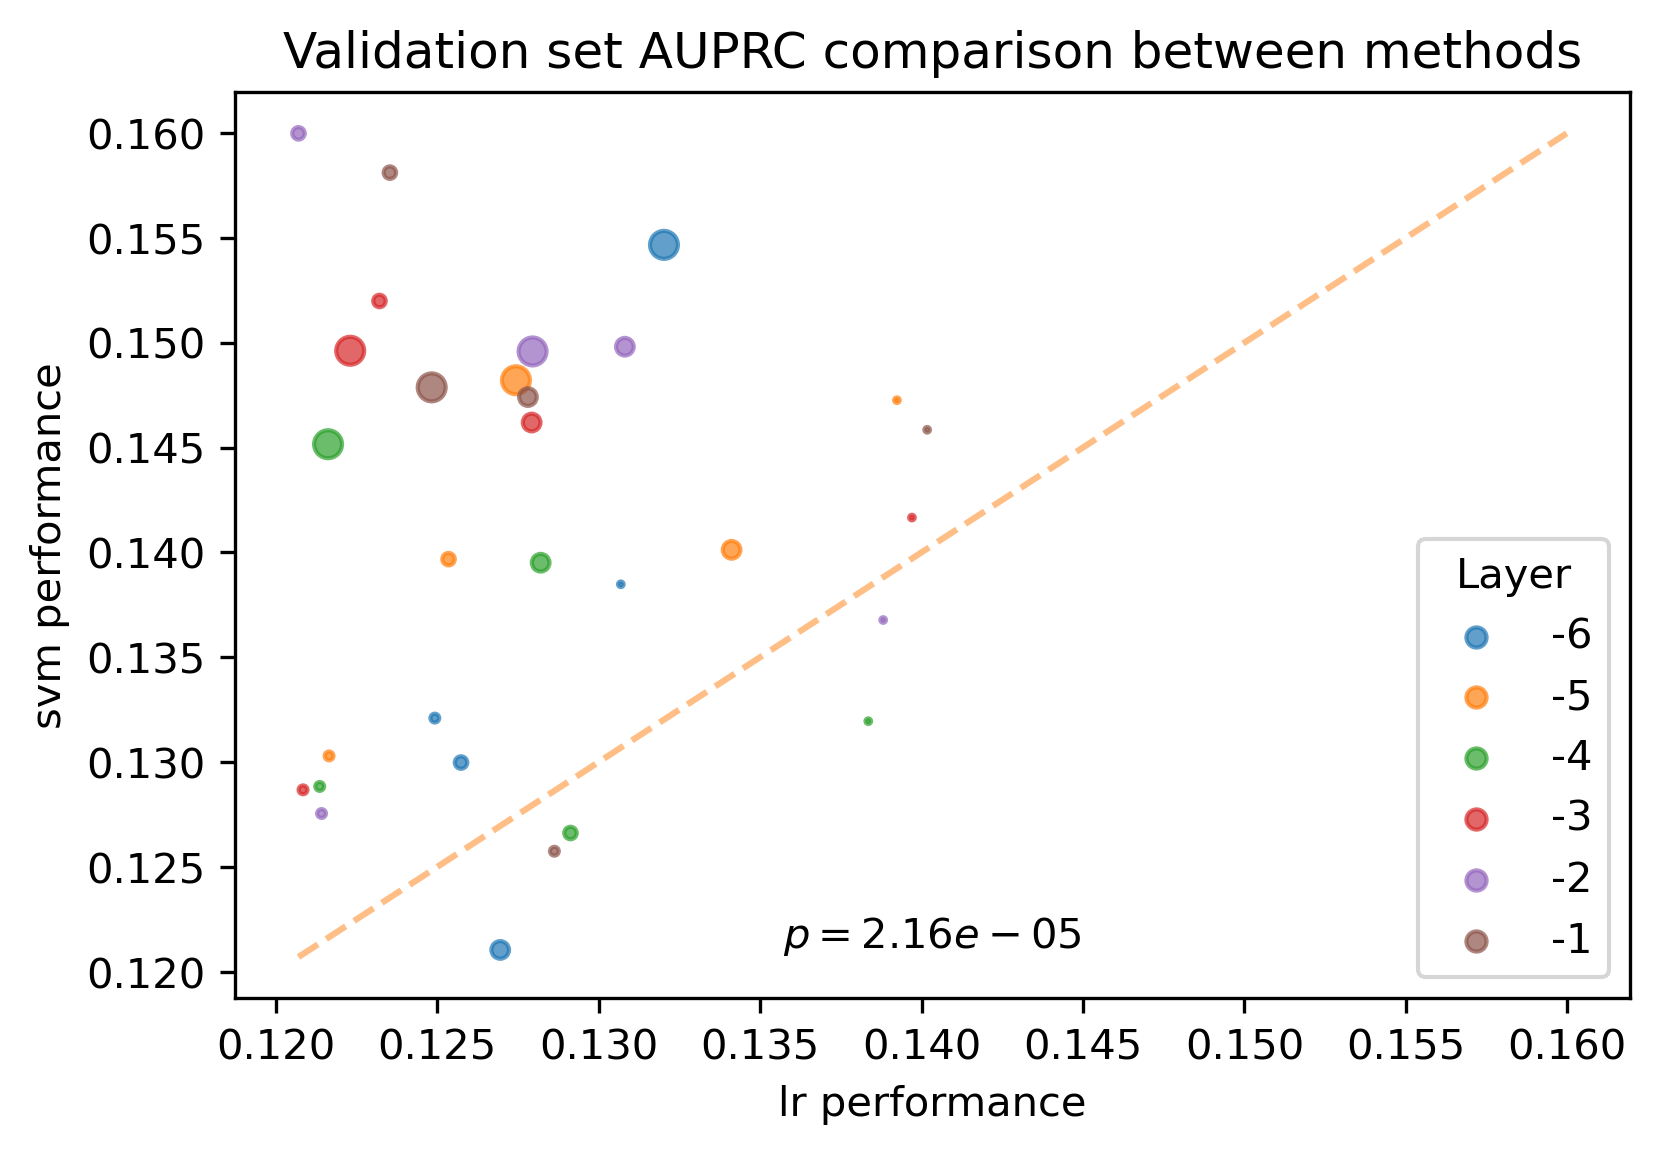

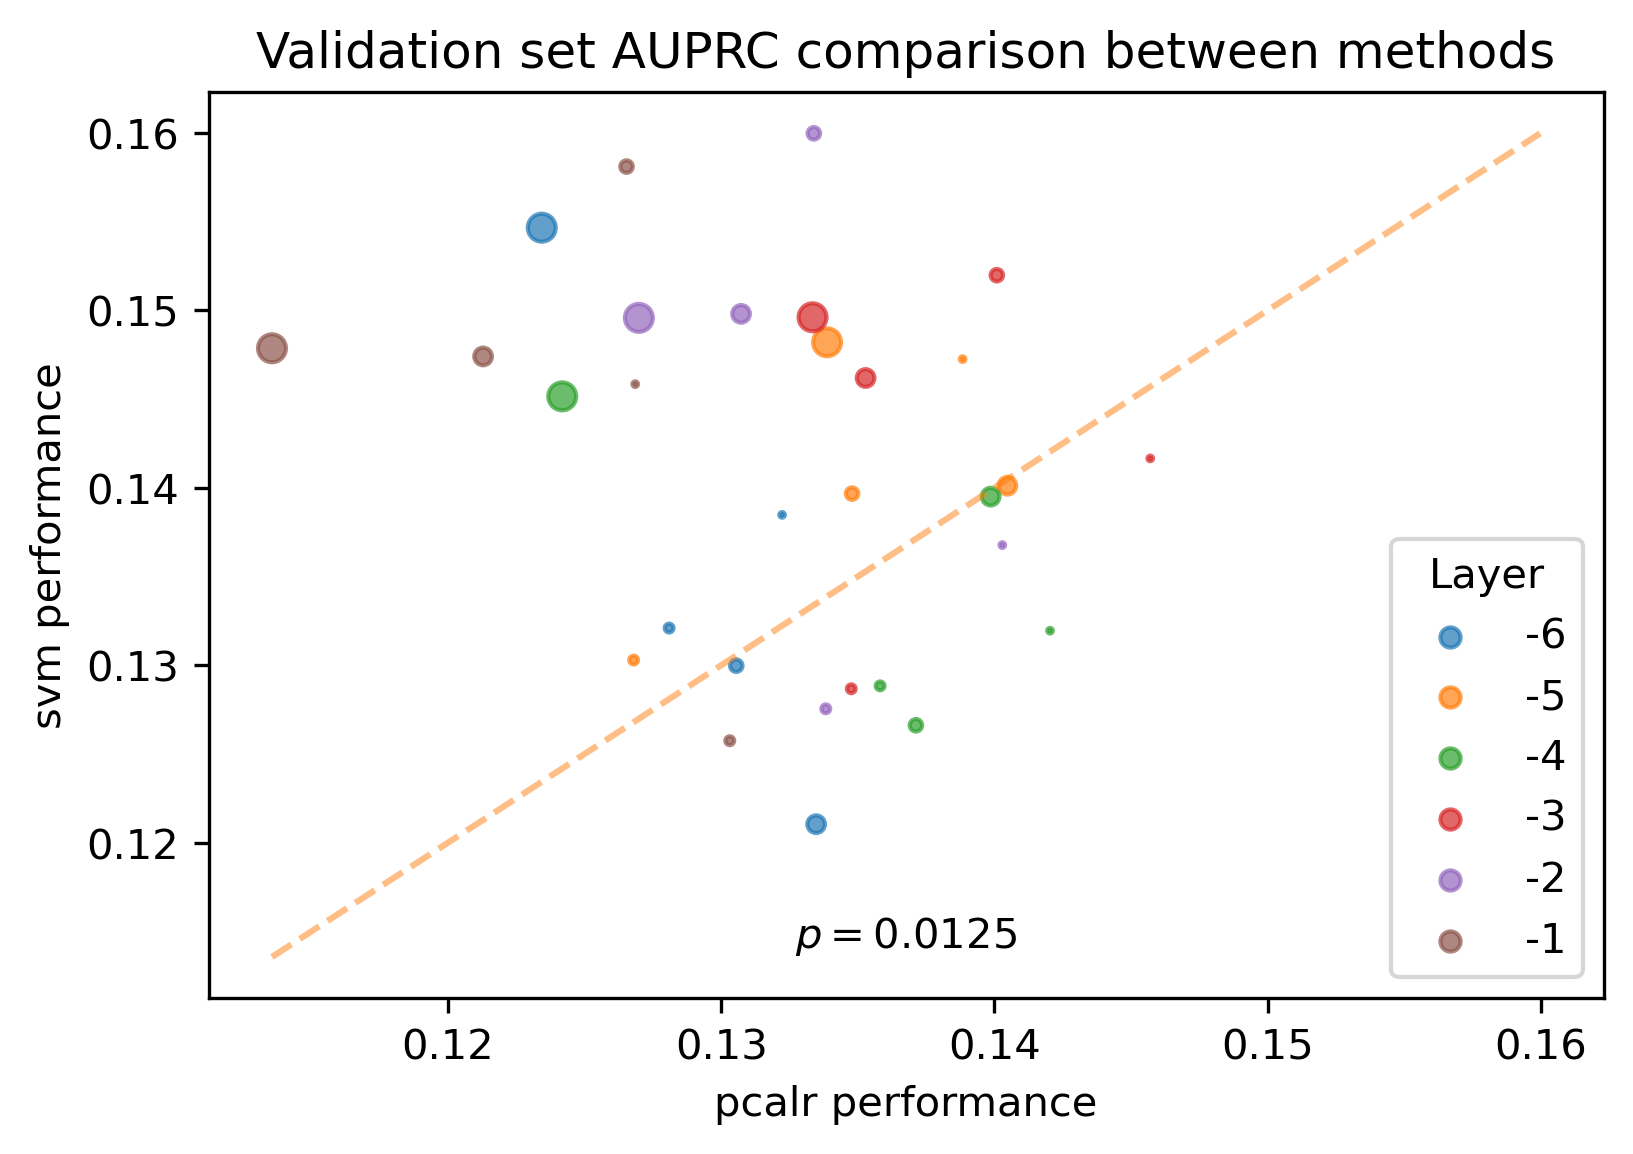

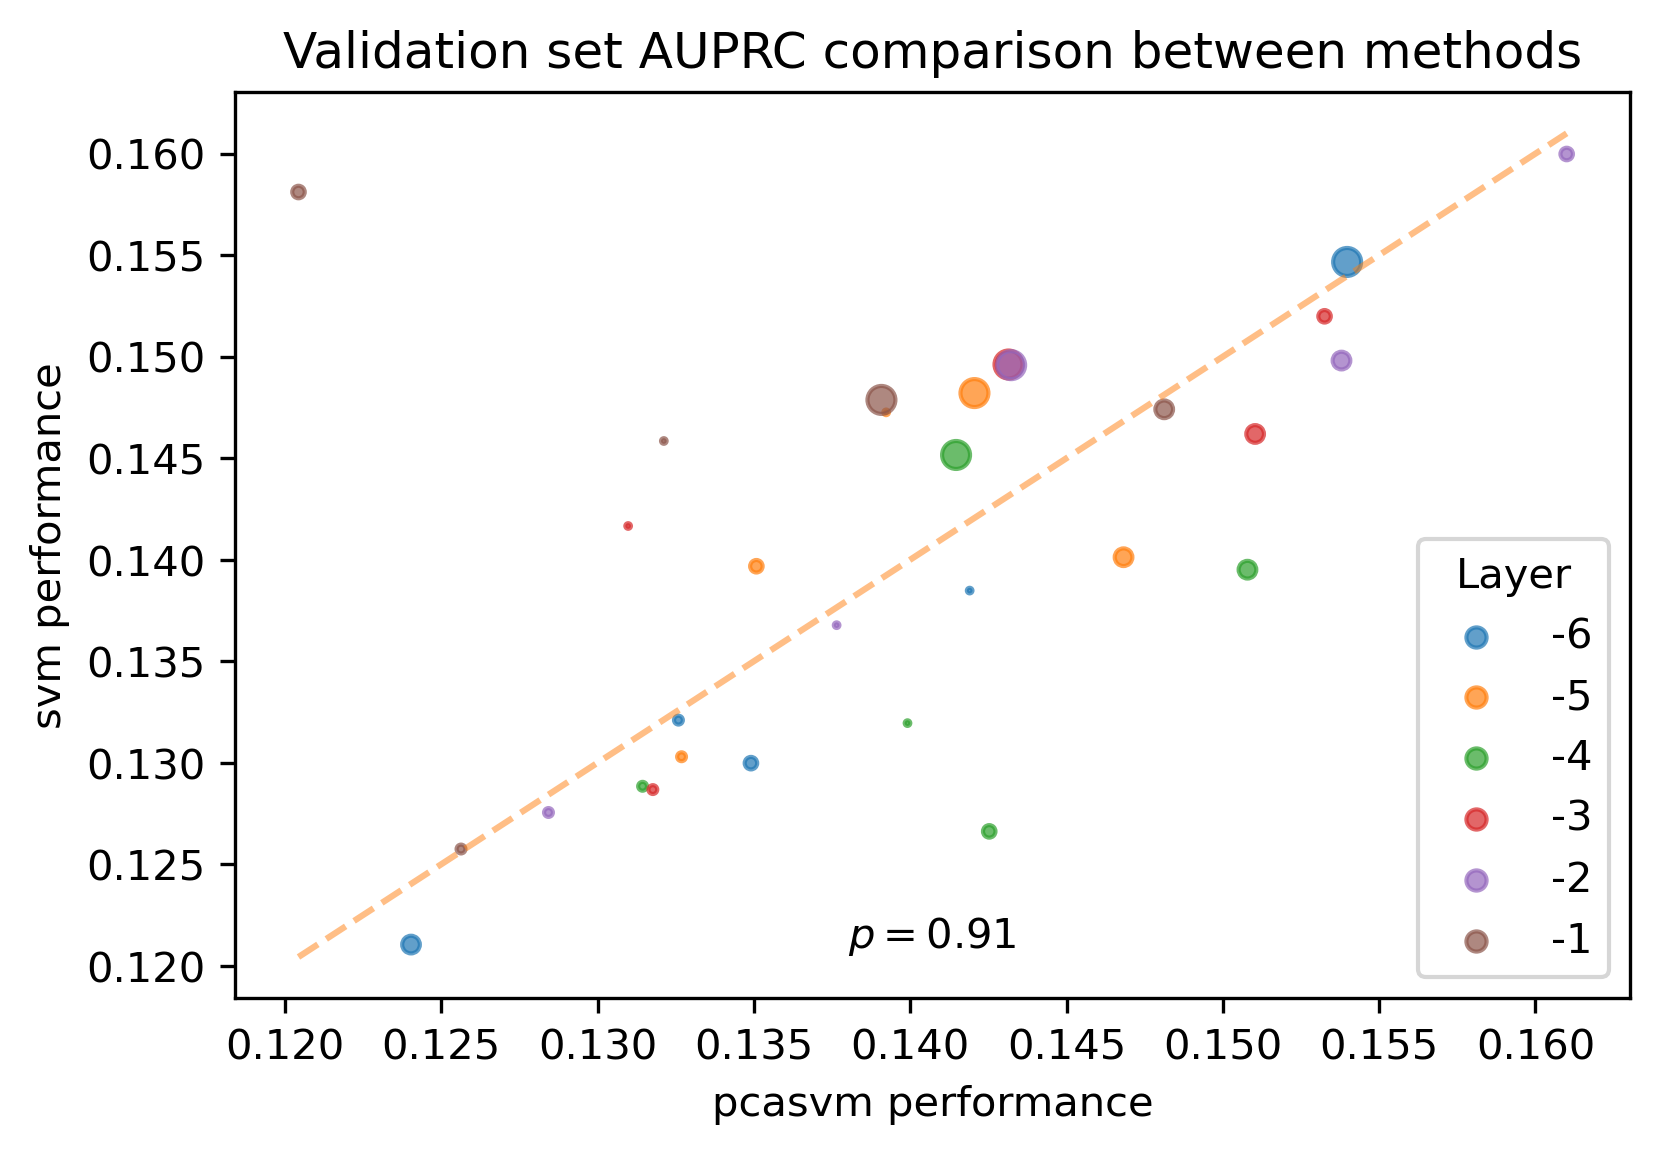

In [64]:
def plot_comparison(x:str, y:str, data=sweep_auprcs, fname=None, **kwargs):
    """Plot a comparison of the two methods given"""
    # Color by layer
    # Size by downsampling
    layers, downsample_levels, cls_methods = extract_unique_keys(data)
    assert x in cls_methods and y in cls_methods
    fig, ax = plt.subplots(dpi=300)
    x_vals, y_vals, colors, sizes = [], [], [], []
    for l, d in itertools.product(layers, downsample_levels):
        x_vals.append(data[(l, d, x)])
        y_vals.append(data[(l, d, y)])
        colors.append(l)
        sizes.append(d)
    
    stat, pval = stats.wilcoxon(x_vals, y_vals)

    for color in sorted(list(set(colors))):
        idx = np.where(np.array(colors) == color)[0]
        ax.scatter(
            [x_vals[i] for i in idx],
            [y_vals[i] for i in idx],
            label=color,
            s=[sizes[i] * 90 for i in idx],
            alpha=0.7,
        )

    minval = np.min(np.concatenate([x_vals, y_vals]))
    maxval = np.max(np.concatenate([x_vals, y_vals]))
    ax.plot([minval, maxval], [minval, maxval], linestyle="dashed", color="tab:orange", alpha=0.5)

    ax.annotate(
        f"$p={pval:.3g}$",
        xy=[np.median([minval, maxval]), minval],
        va='bottom', ha='center',
    )

    ax.legend(title="Layer")
    ax.set(
        xlabel=f"{x} performance",
        ylabel=f"{y} performance",
        **kwargs,
    )
    if fname is not None:
        fig.savefig(fname, bbox_inches='tight')
    return fig

plot_comparison('lr', 'svm', title="Validation set AUPRC comparison between methods").show()
plot_comparison('pcalr', 'svm', title="Validation set AUPRC comparison between methods").show()
plot_comparison('pcasvm', 'svm', title="Validation set AUPRC comparison between methods").show()